# MARCOS JOSÉ AZEVEDO

# TESTE - GRUPO ZAP

Importar dados JSON de uma url do Grupo Zap e estimar, de forma automática, o preço para venda dos imóveis anunciados. 

- Arquivo csv com os preços dos anúncios com os campos: [id, price];
- Explicação da solução;
- Código fonte da solução;
- Respostas (com insumos para suporte) para as seguintes questões:
    - Você utilizaria a métrica escolhida para seleção de modelo também para comunicar os resultados para usuários e    stakeholders internos? Em caso negativo, qual outra métrica você utilizaria nesse caso?
    - Em quais bairros ou em quais faixas de preço o seu modelo performa melhor?
    - Se você tivesse que estimar o valor dos imóveis com apenas 3 campos, quais seriam eles?
    - Como você vislumbra colocar a sua solução em produção?

# Importando as Bibliotecas

In [1]:
import json
import pandas as pd
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.datasets import make_classification

import warnings
warnings.filterwarnings('ignore')
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster


# Importando o arquivo Treino

In [2]:
url_treino = "https://s3.amazonaws.com/grupozap-data-challenge/data/source-4-ds-train.json.zip"

In [3]:
json = pd.read_json(url_treino, encoding="utf8", lines=True)

In [4]:
json.head(3)

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos
0,388.0,"04 dorms sendo 01 suíte e closet, sala de esta...",PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,2017-02-07T13:21:40Z,f4603b2b52,TWO_STORY_HOUSE,ACTIVE,787c7bd19d,6.0,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04290030', 'city...",1.0,STANDARD,3.0,388.0,4.0,"{'price': 700000, 'businessType': 'SALE'}"
1,129.0,"03 dorms sendo 01 suíte, sala, sala de jantar,...",PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,2016-03-21T18:35:17Z,f4603b2b52,HOME,ACTIVE,4d68c0cdbe,2.0,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04187320', 'city...",1.0,STANDARD,2.0,129.0,3.0,"{'price': 336000, 'businessType': 'SALE'}"
2,396.0,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",Excelente Conjunto Comercial na Av. Paulista,2018-12-18T23:47:03.425Z,501f6d5e94,COMMERCIAL_PROPERTY,ACTIVE,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,"{'country': '', 'zipCode': '01311000', 'city':...",0.0,STANDARD,4.0,NaN,0.0,"{'period': 'MONTHLY', 'yearlyIptu': 4040, 'pri..."


# Normalizando as colunas 

### Coluna "pricingInfos" e coluna ''address"

In [5]:
df_treino = (pd.DataFrame(json['pricingInfos']
                     .values.tolist())
                     .add_prefix('pricingInfos_')
                     .join(json.drop('pricingInfos', 1)))

In [6]:
df_treino = (pd.DataFrame(df_treino['address']
                     .values.tolist())
                     .add_prefix('address_')
                     .join(df_treino.drop('address', 1)))

In [7]:
df_treino.head(3)

,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation,address_street,address_locationId,address_district,address_unitNumber,...,id,parkingSpaces,updatedAt,owner,images,suites,publicationType,bathrooms,totalAreas,bedrooms
0,BR,04290030,São Paulo,53,Zona Sul,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,...,787c7bd19d,6.0,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.0,STANDARD,3.0,388.0,4.0
1,BR,04187320,São Paulo,16,Zona Sul,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Juruaba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,,,...,4d68c0cdbe,2.0,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.0,STANDARD,2.0,129.0,3.0
2,,01311000,São Paulo,402,,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,...,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,0.0,STANDARD,4.0,NaN,0.0


### Nota: A coluna "address.geoLocation" possui mais dois níveis e é necessária normalização também para  a correta leitura dos dados

#### Extraindo os dados de Precisão (geoLocation.precision)

In [8]:
s = df_treino['address_geoLocation'].apply(pd.Series).add_prefix("geoLocation_")

In [9]:
s.head(3)

,geoLocation_0,geoLocation_location,geoLocation_precision
0,NaN,"{'lon': -46.614222, 'lat': -23.612923}",ROOFTOP
1,NaN,"{'lon': -46.593475, 'lat': -23.643962}",RANGE_INTERPOLATED
2,NaN,"{'lon': -46.647452, 'lat': -23.568559}",ROOFTOP


#### Concatenando o resultado com o dataframe principal

In [10]:
df_treino = pd.concat([df_treino.drop(["address_geoLocation"], axis=1), s], axis=1)

#### Extraindo os dados de Localização (geoLocation.location = latitude & longitude)

In [11]:
geolocation = df_treino['geoLocation_location'].apply(pd.Series).add_prefix("geolocation_")

In [12]:
geolocation.head(3)

,geolocation_0,geolocation_lat,geolocation_lon
0,NaN,-23.612923,-46.614222
1,NaN,-23.643962,-46.593475
2,NaN,-23.568559,-46.647452


#### Concatenando o resultado com o dataframe principal

In [13]:
df_treino = pd.concat([df_treino.drop(["geoLocation_location"], axis=1), geolocation], axis=1)

In [14]:
df_treino.head(3)

,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_street,address_locationId,address_district,address_unitNumber,address_state,...,suites,publicationType,bathrooms,totalAreas,bedrooms,geoLocation_0,geoLocation_precision,geolocation_0,geolocation_lat,geolocation_lon
0,BR,04290030,São Paulo,53,Zona Sul,Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,São Paulo,...,1.0,STANDARD,3.0,388.0,4.0,NaN,ROOFTOP,NaN,-23.612923,-46.614222
1,BR,04187320,São Paulo,16,Zona Sul,Rua Juruaba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,,,São Paulo,...,1.0,STANDARD,2.0,129.0,3.0,NaN,RANGE_INTERPOLATED,NaN,-23.643962,-46.593475
2,,01311000,São Paulo,402,,Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,São Paulo,...,0.0,STANDARD,4.0,NaN,0.0,NaN,ROOFTOP,NaN,-23.568559,-46.647452


#### Apagando colunas desnecessárias

In [15]:
colunas_apagar = ['geolocation_0', 'geoLocation_0']

In [16]:
df_treino = df_treino.drop(colunas_apagar, 1)

In [17]:
df_treino.head(3)

,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_street,address_locationId,address_district,address_unitNumber,address_state,...,owner,images,suites,publicationType,bathrooms,totalAreas,bedrooms,geoLocation_precision,geolocation_lat,geolocation_lon
0,BR,04290030,São Paulo,53,Zona Sul,Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,São Paulo,...,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.0,STANDARD,3.0,388.0,4.0,ROOFTOP,-23.612923,-46.614222
1,BR,04187320,São Paulo,16,Zona Sul,Rua Juruaba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,,,São Paulo,...,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.0,STANDARD,2.0,129.0,3.0,RANGE_INTERPOLATED,-23.643962,-46.593475
2,,01311000,São Paulo,402,,Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,São Paulo,...,False,[http://static.nidoimovel.com.br/d3d9446802a44...,0.0,STANDARD,4.0,NaN,0.0,ROOFTOP,-23.568559,-46.647452


# Criando o DataFrame exclusivo para imóveis à VENDA

In [18]:
df_treino['pricingInfos_businessType'].value_counts(dropna=False).nlargest()

SALE      105332
RENTAL     28632
Name: pricingInfos_businessType, dtype: int64

In [19]:
df_treino = df_treino[(df_treino['pricingInfos_businessType']=='SALE')]

In [20]:
df_treino['pricingInfos_businessType'].value_counts(dropna=False).nlargest()

SALE    105332
Name: pricingInfos_businessType, dtype: int64

In [21]:
df_treino['listingStatus'].value_counts(dropna=False).nlargest()

ACTIVE    105332
Name: listingStatus, dtype: int64

# Analisando os dados

In [22]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105332 entries, 0 to 133962
Data columns (total 37 columns):
address_country                  105332 non-null object
address_zipCode                  105332 non-null object
address_city                     105332 non-null object
address_streetNumber             105332 non-null object
address_zone                     105332 non-null object
address_street                   105332 non-null object
address_locationId               105332 non-null object
address_district                 105332 non-null object
address_unitNumber               105332 non-null object
address_state                    105332 non-null object
address_neighborhood             105332 non-null object
pricingInfos_price               105332 non-null int64
pricingInfos_businessType        105332 non-null object
pricingInfos_period              419 non-null object
pricingInfos_yearlyIptu          87587 non-null float64
pricingInfos_rentalTotalPrice    95 non-null float64


In [59]:
df_treino['usableAreas'].value_counts(dropna=False).nlargest(7)

50.0     2697
70.0     2202
60.0     2177
100.0    1910
0.0      1883
120.0    1818
65.0     1547
Name: usableAreas, dtype: int64

In [24]:
df_treino['pricingInfos_price'].value_counts(dropna=False).nlargest(7)

455000    1742
595000    1704
385000    1649
525000    1642
315000    1614
244999    1452
840000    1380
Name: pricingInfos_price, dtype: int64

In [25]:
df_treino['address_zipCode'].value_counts(dropna=False).nlargest()

            4658
00000000    1406
02675031     890
05734140     208
01240001     196
Name: address_zipCode, dtype: int64

In [26]:
df_treino['geoLocation_precision'].value_counts(dropna=False).nlargest()

ROOFTOP               56954
GEOMETRIC_CENTER      30595
RANGE_INTERPOLATED    11997
APPROXIMATE            5753
NO_GEOCODE               27
Name: geoLocation_precision, dtype: int64

#### Verificando a correlação entre as features

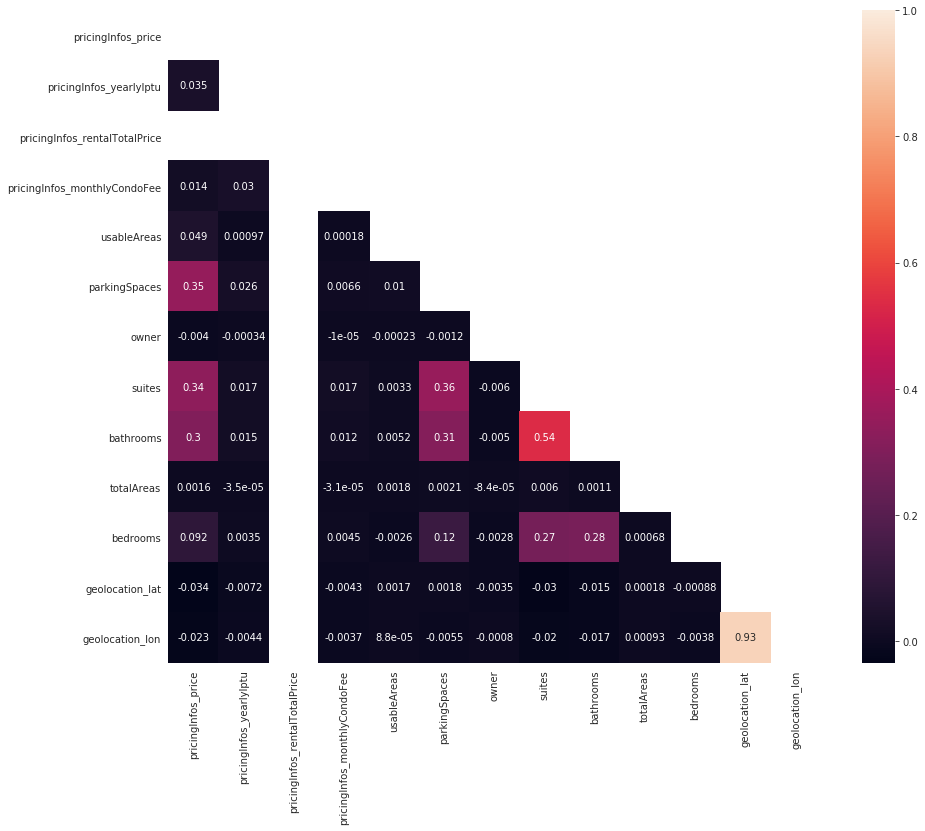

In [27]:
corr = df_treino.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15, 12));
    
    sns.heatmap(
        corr,
        ax=ax,
        annot=True,
        mask=mask,
        square=True
    );

### Histograma do valor de venda dos imóveis

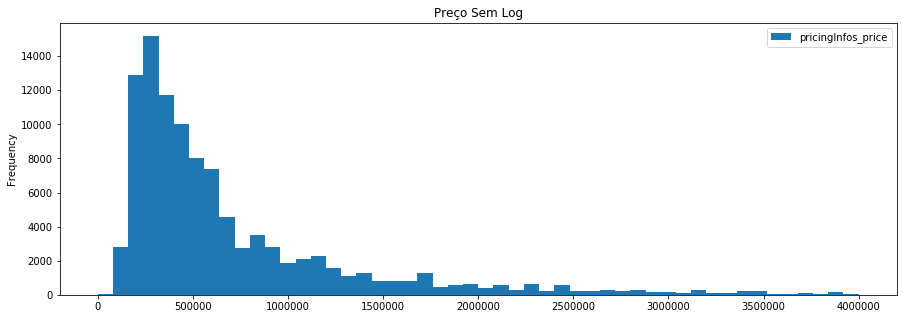

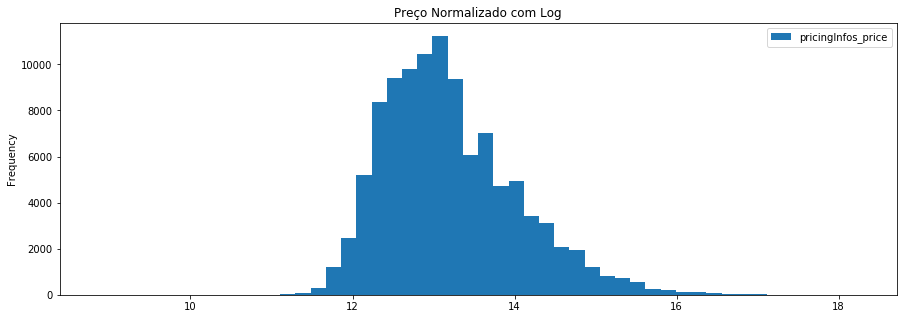

In [28]:
df_treino[['pricingInfos_price']].plot(
    kind='hist',
    range=(0,4000000),
    figsize=(15, 5),
    bins=50,
    title='Preço Sem Log'
);

np.log1p(df_treino[['pricingInfos_price']]).plot(
    kind='hist',    
    figsize=(15, 5),
    bins=50,
    title='Preço Normalizado com Log'
);

### A Variável pricingInfos.price é bastante assimétrica e normalizada fica mais próxima de uma distribuição normal.

#### Aplicando a função Skew (teste Box-Cox2) para ver se há a necessidade de normalizar pelo Log

In [29]:
from scipy.stats import skew

In [30]:
sk = skew(df_treino['pricingInfos_price'])
print(sk)

13.881532025060867


##### Valores mais próxmos de zero (cerca de 0.75 para menos) não precisam de normalização. O resultado ficou acima disso. Portanto, vou normalizar essa variável.<br>
##### Apenas verificando o valor com o log, qual seu resultado:

In [31]:
sk = skew(np.log1p(df_treino['pricingInfos_price']))
print(sk)

0.8236765887251024


# Rodando Regressões

## Rodando a Regressão com Log

### Testando a variável usableAereas (metragem do imóvel)

In [32]:
function1 = '''np.log1p(pricingInfos_price) ~
 + np.log1p(usableAreas)
 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())


                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.376
Model:                                      OLS   Adj. R-squared:                  0.376
Method:                           Least Squares   F-statistic:                 6.308e+04
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:11:27   Log-Likelihood:            -1.0371e+05
No. Observations:                        104646   AIC:                         2.074e+05
Df Residuals:                            104644   BIC:                         2.074e+05
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

#### Passei o log na variável usableAreas pois faz diferença no resultado. Sem log o R2 é de 0.001

In [33]:
function1 = '''np.log1p(pricingInfos_price) ~
 + usableAreas
 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.001
Model:                                      OLS   Adj. R-squared:                  0.001
Method:                           Least Squares   F-statistic:                     96.06
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):           1.14e-22
Time:                                  17:11:34   Log-Likelihood:            -1.2834e+05
No. Observations:                        104646   AIC:                         2.567e+05
Df Residuals:                            104644   BIC:                         2.567e+05
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Testando 3 variáveis em conjunto

In [89]:
function1 = '''np.log1p(pricingInfos_price) ~
 + bedrooms
 + np.log1p(usableAreas)
 + parkingSpaces
 
 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.435
Model:                                      OLS   Adj. R-squared:                  0.435
Method:                           Least Squares   F-statistic:                 2.613e+04
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:37:24   Log-Likelihood:                -95402.
No. Observations:                        101915   AIC:                         1.908e+05
Df Residuals:                            101911   BIC:                         1.908e+05
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [90]:
function1 = '''np.log1p(pricingInfos_price) ~
 + bathrooms
 + suites
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.511
Model:                                      OLS   Adj. R-squared:                  0.511
Method:                           Least Squares   F-statistic:                 3.328e+04
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:37:38   Log-Likelihood:                -83175.
No. Observations:                         95626   AIC:                         1.664e+05
Df Residuals:                             95622   BIC:                         1.664e+05
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [91]:
function1 = '''np.log1p(pricingInfos_price) ~
 + bedrooms
 + bathrooms 
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.453
Model:                                      OLS   Adj. R-squared:                  0.453
Method:                           Least Squares   F-statistic:                 2.877e+04
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:38:02   Log-Likelihood:                -95916.
No. Observations:                        104015   AIC:                         1.918e+05
Df Residuals:                            104011   BIC:                         1.919e+05
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [93]:
function1 = '''np.log1p(pricingInfos_price) ~
 + bedrooms
 + pricingInfos_monthlyCondoFee 
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.367
Model:                                      OLS   Adj. R-squared:                  0.367
Method:                           Least Squares   F-statistic:                 1.750e+04
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:41:31   Log-Likelihood:                -90784.
No. Observations:                         90684   AIC:                         1.816e+05
Df Residuals:                             90680   BIC:                         1.816e+05
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [94]:
function1 = '''np.log1p(pricingInfos_price) ~
 + bedrooms
 + address_zone 
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.396
Model:                                      OLS   Adj. R-squared:                  0.396
Method:                           Least Squares   F-statistic:                     9739.
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:43:36   Log-Likelihood:            -1.0118e+05
No. Observations:                        104053   AIC:                         2.024e+05
Df Residuals:                            104045   BIC:                         2.025e+05
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

### Testando com mais variáveis

In [63]:
function1 = '''np.log1p(pricingInfos_price) ~
 + pricingInfos_monthlyCondoFee
 + bedrooms
 + bathrooms
 + suites
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.526
Model:                                      OLS   Adj. R-squared:                  0.526
Method:                           Least Squares   F-statistic:                 1.878e+04
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:24:46   Log-Likelihood:                -72506.
No. Observations:                         84489   AIC:                         1.450e+05
Df Residuals:                             84483   BIC:                         1.451e+05
Df Model:                                     5                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

### Testando a variável unitTypes

In [64]:
function1 = '''np.log1p(pricingInfos_price) ~
 + unitTypes
 + pricingInfos_monthlyCondoFee
 + bedrooms
 + bathrooms
 + suites
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.580
Model:                                      OLS   Adj. R-squared:                  0.580
Method:                           Least Squares   F-statistic:                     5310.
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:24:57   Log-Likelihood:                -67390.
No. Observations:                         84489   AIC:                         1.348e+05
Df Residuals:                             84466   BIC:                         1.350e+05
Df Model:                                    22                                         
Covariance Type:                      nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--

### Testando a variável address_zone

In [65]:
function1 = '''np.log1p(pricingInfos_price) ~
 + address_zone
 + unitTypes
 + pricingInfos_monthlyCondoFee
 + bedrooms
 + bathrooms
 + suites
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.592
Model:                                      OLS   Adj. R-squared:                  0.591
Method:                           Least Squares   F-statistic:                     4531.
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:25:06   Log-Likelihood:                -66246.
No. Observations:                         84489   AIC:                         1.325e+05
Df Residuals:                             84461   BIC:                         1.328e+05
Df Model:                                    27                                         
Covariance Type:                      nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--

### Testando a variável parkingSpace

In [66]:
function1 = '''np.log1p(pricingInfos_price) ~
 + parkingSpaces
 + address_zone
 + unitTypes
 + pricingInfos_monthlyCondoFee
 + bedrooms
 + bathrooms
 + suites
 + + np.log1p(usableAreas)

 '''
model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.617
Model:                                      OLS   Adj. R-squared:                  0.617
Method:                           Least Squares   F-statistic:                     4821.
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:25:13   Log-Likelihood:                -62873.
No. Observations:                         83823   AIC:                         1.258e+05
Df Residuals:                             83794   BIC:                         1.261e+05
Df Model:                                    28                                         
Covariance Type:                      nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--

### Preço x Algumas Variáveis - Sem Log

In [67]:
function1 = ''' pricingInfos_price ~
 + parkingSpaces
 + suites
 + bathrooms
 + bedrooms
 + geolocation_lat
 + geolocation_lon
 + usableAreas 
 + unitTypes
 + geoLocation_precision
 + address_zone
 + pricingInfos_monthlyCondoFee

 '''

model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:     pricingInfos_price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1020.
Date:                Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:25:24   Log-Likelihood:            -1.2926e+06
No. Observations:               83817   AIC:                         2.585e+06
Df Residuals:                   83782   BIC:                         2.586e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

 __OBSERVAÇÕES:<br>
R quadrado = 0.293 <br>
Os betas estão próximos de zero. Fazendo o mesmo estudo mas passando o LOG na variável pricingInfos_price.__

### Preço x Algumas Variáveis - Com Log

In [68]:
function1 = '''np.log1p(pricingInfos_price) ~
 + parkingSpaces
 + suites
 + bathrooms
 + bedrooms
 + geolocation_lat
 + geolocation_lon
 + np.log1p(usableAreas)
 + unitTypes
 + geoLocation_precision
 + address_zone
 + pricingInfos_monthlyCondoFee 

 '''

model1 = smf.ols(function1, df_treino).fit()
print(model1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(pricingInfos_price)   R-squared:                       0.632
Model:                                      OLS   Adj. R-squared:                  0.632
Method:                           Least Squares   F-statistic:                     4240.
Date:                          Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                                  17:25:47   Log-Likelihood:                -61140.
No. Observations:                         83817   AIC:                         1.224e+05
Df Residuals:                             83782   BIC:                         1.227e+05
Df Model:                                    34                                         
Covariance Type:                      nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975

 __Observações:<br>
Passando o log no preço e no tamanho do imóvel, o R2 foi para 0.632 e os resultados estão mais legíveis.<br>
Quase todos os betas estão dentro do intervalo de confiança.<br>
A variável 'suites' de beta = 0.25022 com p_value = 0 tem uma boa significância no valor.<br>
Poucos betas não tem significância/relevância com p_value maior que 0.05.__<br>


# Tratando as Variáveis

### Criando colunas com log

In [69]:
df_treino['usableAreas'].fillna(df_treino['usableAreas'].mean(),inplace=True)

In [70]:
df_treino['log_usableAreas'] = np.log1p(df_treino['usableAreas'])

### Definindo as colunas

In [72]:
df_modelo = df_treino[[ 'address_zone',
                        'address_neighborhood',                        
                        'pricingInfos_monthlyCondoFee',
                        'usableAreas',
                        'unitTypes',
                        'parkingSpaces',
                        'suites',
                        'bathrooms',
                        'totalAreas',
                        'bedrooms',
                        'geoLocation_precision',
                        'geolocation_lat',
                        'geolocation_lon',
                        'pricingInfos_price',
                        'log_usableAreas'
                      ]]

In [73]:
df_modelo.isnull().sum()

address_zone                        0
address_neighborhood                0
pricingInfos_monthlyCondoFee    14017
usableAreas                         0
unitTypes                           0
parkingSpaces                    2965
suites                           9705
bathrooms                         668
totalAreas                      33975
bedrooms                         1279
geoLocation_precision               6
geolocation_lat                     6
geolocation_lon                     6
pricingInfos_price                  0
log_usableAreas                     0
dtype: int64

#### Tratando com zero as variáveis de geoLocation

In [74]:
df_modelo['geoLocation_precision'].fillna(0, inplace=True)
df_modelo['geolocation_lat'].fillna(0, inplace=True)
df_modelo['geolocation_lon'].fillna(0, inplace=True)
df_modelo['parkingSpaces'].fillna(0, inplace=True)

#### Tratando as demais variáveis com a média

In [75]:
df_modelo['pricingInfos_monthlyCondoFee'].fillna(df_modelo['pricingInfos_monthlyCondoFee'].mean(),inplace=True)
df_modelo['suites'].fillna(df_modelo['suites'].mean(),inplace=True)
df_modelo['bathrooms'].fillna(df_modelo['bathrooms'].mean(),inplace=True)
df_modelo['totalAreas'].fillna(df_modelo['totalAreas'].mean(),inplace=True)
df_modelo['bedrooms'].fillna(df_modelo['bedrooms'].mean(),inplace=True)



In [76]:
df_modelo['address_zone'] = df_modelo['address_zone'].replace('', np.nan)
df_modelo['address_zone'].fillna('Não Informado', inplace=True)

In [77]:
df_modelo.isnull().sum()

address_zone                    0
address_neighborhood            0
pricingInfos_monthlyCondoFee    0
usableAreas                     0
unitTypes                       0
parkingSpaces                   0
suites                          0
bathrooms                       0
totalAreas                      0
bedrooms                        0
geoLocation_precision           0
geolocation_lat                 0
geolocation_lon                 0
pricingInfos_price              0
log_usableAreas                 0
dtype: int64

In [78]:
df_modelo.shape

(105332, 15)

# Criando Dummies

In [79]:
df_modelo = pd.get_dummies(df_modelo, columns=[ 'unitTypes', 'address_zone', 'address_neighborhood'])

In [80]:
df_modelo.head()

,pricingInfos_monthlyCondoFee,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,geoLocation_precision,geolocation_lat,geolocation_lon,...,address_neighborhood_Vl. Pauliceia,address_neighborhood_Vl. Prudente,address_neighborhood_Várzea da Barra Funda,address_neighborhood_Várzea de Baixo,address_neighborhood_itaim,address_neighborhood_vila prudente,address_neighborhood_Água Branca,address_neighborhood_Água Fria,address_neighborhood_Água Funda,address_neighborhood_Água Rasa
0,1478.61128,388.0,6.0,1.0,3.0,388.0,4.0,ROOFTOP,-23.612923,-46.614222,...,0,0,0,0,0,0,0,0,0,0
1,1478.61128,129.0,2.0,1.0,2.0,129.0,3.0,RANGE_INTERPOLATED,-23.643962,-46.593475,...,0,0,0,0,0,0,0,0,0,0
3,686.00000,80.0,2.0,1.0,2.0,80.0,3.0,RANGE_INTERPOLATED,-23.598023,-46.682781,...,0,0,0,0,0,0,0,0,0,0
4,6230.00000,3322.0,5.0,4.0,5.0,332.0,4.0,RANGE_INTERPOLATED,-23.582497,-46.653027,...,0,0,0,0,0,0,0,0,0,0
6,1120.00000,94.0,2.0,0.0,1.0,0.0,3.0,ROOFTOP,-23.561318,-46.686355,...,0,0,0,0,0,0,0,0,0,0


In [81]:
df_modelo.shape

(105332, 1617)

# Criando o Modelo

### Definindo o X e o y

In [82]:
df_numeric = df_modelo.select_dtypes(include=[np.number])

In [83]:
X = df_numeric.drop(['pricingInfos_price'], axis=1)
y = np.log1p(df_numeric['pricingInfos_price'])

In [84]:
X.shape

(105332, 1615)

In [85]:
y.shape

(105332,)

### Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
X_train.dtypes

pricingInfos_monthlyCondoFee          float64
usableAreas                           float64
parkingSpaces                         float64
suites                                float64
bathrooms                             float64
                                       ...   
address_neighborhood_vila prudente      uint8
address_neighborhood_Água Branca        uint8
address_neighborhood_Água Fria          uint8
address_neighborhood_Água Funda         uint8
address_neighborhood_Água Rasa          uint8
Length: 1615, dtype: object

### Escolhendo o Melhor Modelo 

SCORE TREINO:  0.7632189641479763
SCORE TESTE:  -5543.44904187807
Model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
****Results****
R2: -5543.449

MSE: 3786.837



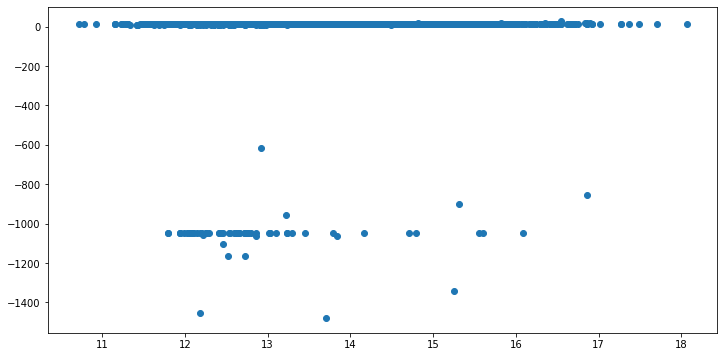

SCORE TREINO:  0.9823356678818542
SCORE TESTE:  0.9065511862820288
Model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
****Results****
R2: 0.9066

MSE: 0.0638



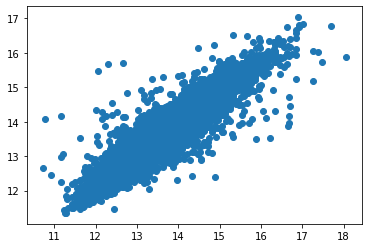

SCORE TREINO:  0.8691284075175747
SCORE TESTE:  0.8691006166787124
Model GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
****Results****
R2: 0.8691

MSE: 0.0894



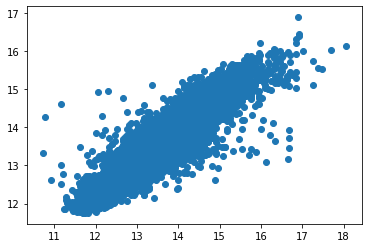

In [88]:
linear_model = LinearRegression()
rforest_model = RandomForestRegressor()
grad_model = GradientBoostingRegressor()

models = [linear_model, rforest_model, grad_model]
plt.figure(figsize=(12,6))

for model in models:
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)

    #Metrics
    r2 = r2_score(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)
    
    print("SCORE TREINO: ", model.score(X_train, y_train))
    print("SCORE TESTE: ", model.score(X_test, y_test))
        
    print("="*30)
    print(f'Model {str(model)}')
    print('****Results****')
    print(f'R2: {round(r2, 4)}\n')  #quanto mais perto de 1 melhor
    print(f'MSE: {round(mse, 4)}\n')   #quanto mais perto de zero melhor
    plt.scatter(y_test, yhat)    
    plt.show()

# Treinando o melhor modelo

In [95]:
rforest_model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [96]:
print("SCORE TREINO: ", rforest_model.score(X_train, y_train))
print("SCORE TESTE: ",rforest_model.score(X_test, y_test))


SCORE TREINO:  0.9825607971728281
SCORE TESTE:  0.9837247609903229


__Os scores de treino e teste ficaram muito altos, vou optar pelo Gradient Boosting Regressor__

In [97]:
grad_model.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
print("SCORE TREINO: ", grad_model.score(X_train, y_train))
print("SCORE TESTE: ",grad_model.score(X_test, y_test))

SCORE TREINO:  0.8687410637354558
SCORE TESTE:  0.8721857608411114


### O score do GradientBoosting indica que tanto o treino quanto o teste tiveram um resultado similar. E como não há disparidades entre eles não há overfitting nem underfitting.

# Features mais importantes

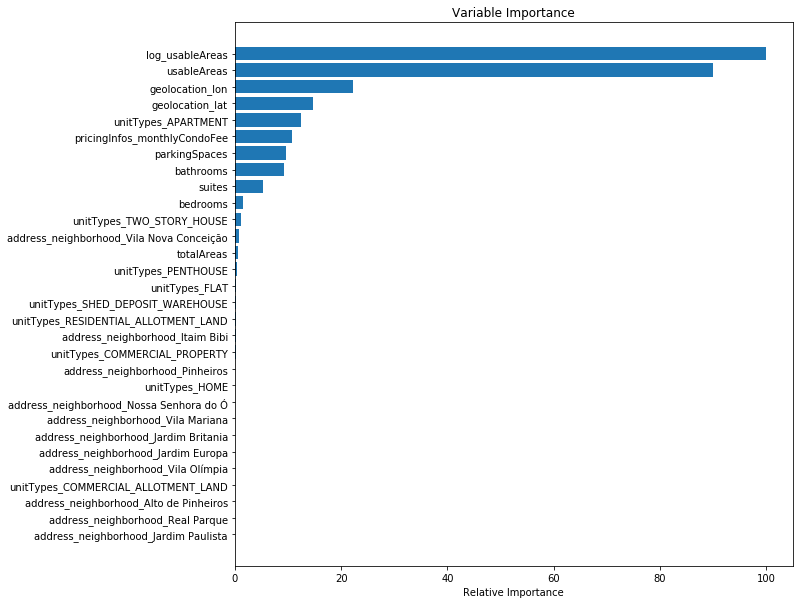

In [99]:
feature_importance = grad_model.feature_importances_
limite = 30

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-limite:]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Importando o arquivo Teste

In [100]:
url_teste = "https://s3.amazonaws.com/grupozap-data-challenge/data/source-4-ds-test.json.zip"

In [101]:
json_teste = pd.read_json(url_teste, encoding="utf8", lines=True)

In [102]:
json_teste.head(3)

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos
0,47.0,Apartamentos de 1 dormitório na Rua Bela Cintr...,Apartamento Bela Cintra,2015-10-20T20:52:41Z,967d57ce20,APARTMENT,ACTIVE,89224365f8,1.0,2018-11-08T15:02:53.953Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '01415000', 'city...",0.0,STANDARD,1.0,47.0,1,"{'price': None, 'businessType': 'SALE'}"
1,55.0,"Ótima localização, próximo ao shopping Central...","Apartamento residencial à venda, Quinta da Pai...",2018-07-31T06:10:07.427Z,bddebf057a,APARTMENT,ACTIVE,363731333f,1.0,2018-11-08T16:10:49.374Z,False,[http://images.ingaiasites.com.br/AolwiwJLLpET...,"{'country': 'BR', 'zipCode': '03152155', 'city...",0.0,STANDARD,0.0,55.0,2,"{'yearlyIptu': 0, 'price': None, 'businessType..."
2,92.0,Apartamento maravilhoso com ampla sala ( abriu...,"Apartamento em Santa Terezinha - São Paulo, SP",2018-01-25T13:57:14.203Z,d7190e8f4c,APARTMENT,ACTIVE,6e6283378a,2.0,2019-02-12T18:29:26.933Z,False,[https://ssl-w08cnn0135.websiteseguro.com/mira...,"{'country': '', 'zipCode': '02461000', 'city':...",1.0,STANDARD,3.0,NaN,3,"{'price': None, 'businessType': 'SALE', 'month..."


In [103]:
json_teste.shape

(16036, 19)

# Normalizando as colunas 

In [104]:
df_teste = (pd.DataFrame(json_teste['pricingInfos']
                     .values.tolist())
                     .add_prefix('pricingInfos_')
                     .join(json_teste.drop('pricingInfos', 1)))

df_teste = (pd.DataFrame(df_teste['address']
                     .values.tolist())
                     .add_prefix('address_')
                     .join(df_teste.drop('address', 1)))

s = df_teste['address_geoLocation'].apply(pd.Series).add_prefix("geoLocation_")
df_teste = pd.concat([df_teste.drop(["address_geoLocation"], axis=1), s], axis=1)
geolocation = df_teste['geoLocation_location'].apply(pd.Series).add_prefix("geolocation_")
df_teste = pd.concat([df_teste.drop(["geoLocation_location"], axis=1), geolocation], axis=1)
colunas_apagar = ['geolocation_0', 'geoLocation_0']
df_teste = df_teste.drop(colunas_apagar, 1)

# Criando o DataFrame Teste para Imóveis à VENDA

In [105]:
df_teste = df_teste[(df_teste['pricingInfos_businessType']=='SALE')]

# Tratando as Variáveis

In [106]:
df_teste['usableAreas'].fillna(df_teste['usableAreas'].mean(),inplace=True)
df_teste['log_usableAreas'] = np.log1p(df_teste['usableAreas'])

df_mod_teste = df_teste[[ 'address_zone',
                        'address_neighborhood',                        
                        'pricingInfos_monthlyCondoFee',
                        'usableAreas',
                        'unitTypes',
                        'parkingSpaces',
                        'suites',
                        'bathrooms',
                        'totalAreas',
                        'bedrooms',
                        'geoLocation_precision',
                        'geolocation_lat',
                        'geolocation_lon',
                        'pricingInfos_price'                                              
                      ]]
df_mod_teste['geoLocation_precision'].fillna(0, inplace=True)
df_mod_teste['geolocation_lat'].fillna(0, inplace=True)
df_mod_teste['geolocation_lon'].fillna(0, inplace=True)

df_teste['geolocation_lat'].fillna(0, inplace=True)
df_teste['geolocation_lon'].fillna(0, inplace=True)

df_mod_teste['pricingInfos_monthlyCondoFee'].fillna(df_mod_teste['pricingInfos_monthlyCondoFee'].mean(),inplace=True)

df_mod_teste['parkingSpaces'].fillna(df_mod_teste['parkingSpaces'].mean(),inplace=True)
df_mod_teste['suites'].fillna(df_mod_teste['suites'].mean(),inplace=True)
df_mod_teste['bathrooms'].fillna(df_mod_teste['bathrooms'].mean(),inplace=True)
df_mod_teste['totalAreas'].fillna(df_mod_teste['totalAreas'].mean(),inplace=True)
df_mod_teste['bedrooms'].fillna(df_mod_teste['bedrooms'].mean(),inplace=True)

df_mod_teste['address_zone'] = df_mod_teste['address_zone'].replace('', np.nan)
df_mod_teste['address_zone'].fillna('Não Informado', inplace=True)


# Criando Dummies

In [107]:
df_mod_teste = pd.get_dummies(df_mod_teste, columns=[ 'unitTypes', 'address_zone', 'address_neighborhood'])

In [108]:
df_mod_teste.head(3)

,pricingInfos_monthlyCondoFee,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,geoLocation_precision,geolocation_lat,geolocation_lon,...,address_neighborhood_Vl Pompeia,address_neighborhood_Vl R Feijo,address_neighborhood_Vl São Francisco,address_neighborhood_Vl. Prudente,address_neighborhood_Várzea da Barra Funda,address_neighborhood_Várzea de Baixo,address_neighborhood_Água Branca,address_neighborhood_Água Fria,address_neighborhood_Água Funda,address_neighborhood_Água Rasa
0,1470.143377,47.0,1.0,0.0,1.0,47.000000,1,GEOMETRIC_CENTER,-23.557225,-46.662765,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,55.0,1.0,0.0,0.0,55.000000,2,ROOFTOP,-23.592852,-46.581879,...,0,0,0,0,0,0,0,0,0,0
2,686.000000,92.0,2.0,1.0,3.0,252.474754,3,ROOFTOP,-23.493609,-46.638456,...,0,0,0,0,0,0,0,0,0,0


In [109]:
X.head(3)

,pricingInfos_monthlyCondoFee,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,geolocation_lat,geolocation_lon,log_usableAreas,...,address_neighborhood_Vl. Pauliceia,address_neighborhood_Vl. Prudente,address_neighborhood_Várzea da Barra Funda,address_neighborhood_Várzea de Baixo,address_neighborhood_itaim,address_neighborhood_vila prudente,address_neighborhood_Água Branca,address_neighborhood_Água Fria,address_neighborhood_Água Funda,address_neighborhood_Água Rasa
0,1478.61128,388.0,6.0,1.0,3.0,388.0,4.0,-23.612923,-46.614222,5.963579,...,0,0,0,0,0,0,0,0,0,0
1,1478.61128,129.0,2.0,1.0,2.0,129.0,3.0,-23.643962,-46.593475,4.867534,...,0,0,0,0,0,0,0,0,0,0
3,686.00000,80.0,2.0,1.0,2.0,80.0,3.0,-23.598023,-46.682781,4.394449,...,0,0,0,0,0,0,0,0,0,0


### Acrescentando dummies que não foram criadas em relação ao arquivo treino

In [110]:
for x in list(X):    
    if x not in list(df_mod_teste):        
        df_mod_teste[x] = 0

In [111]:
df_mod_teste.head(3)

,pricingInfos_monthlyCondoFee,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,geoLocation_precision,geolocation_lat,geolocation_lon,...,address_neighborhood_Vl Monumento/Ipiran,address_neighborhood_Vl Paranagua,address_neighborhood_Vl. Iza,address_neighborhood_Vl. Mariana,address_neighborhood_Vl. Mazzei,address_neighborhood_Vl. Monte Alegre,address_neighborhood_Vl. Nova Conceic,address_neighborhood_Vl. Pauliceia,address_neighborhood_itaim,address_neighborhood_vila prudente
0,1470.143377,47.0,1.0,0.0,1.0,47.000000,1,GEOMETRIC_CENTER,-23.557225,-46.662765,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,55.0,1.0,0.0,0.0,55.000000,2,ROOFTOP,-23.592852,-46.581879,...,0,0,0,0,0,0,0,0,0,0
2,686.000000,92.0,2.0,1.0,3.0,252.474754,3,ROOFTOP,-23.493609,-46.638456,...,0,0,0,0,0,0,0,0,0,0


# Fazendo a previsão dos valores

### Criando dataframe com as variáveis numéricas

In [112]:
df_numeric_teste = df_mod_teste.select_dtypes(include=[np.number])

### Equiparando as colunas dos datasets Treino e Teste

In [113]:
X_Real = df_numeric_teste[list(X)]

In [114]:
X_Real.head()

,pricingInfos_monthlyCondoFee,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,geolocation_lat,geolocation_lon,log_usableAreas,...,address_neighborhood_Vl. Pauliceia,address_neighborhood_Vl. Prudente,address_neighborhood_Várzea da Barra Funda,address_neighborhood_Várzea de Baixo,address_neighborhood_itaim,address_neighborhood_vila prudente,address_neighborhood_Água Branca,address_neighborhood_Água Fria,address_neighborhood_Água Funda,address_neighborhood_Água Rasa
0,1470.143377,47.0,1.0,0.0,1.0,47.000000,1,-23.557225,-46.662765,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,55.0,1.0,0.0,0.0,55.000000,2,-23.592852,-46.581879,0,...,0,0,0,0,0,0,0,0,0,0
2,686.000000,92.0,2.0,1.0,3.0,252.474754,3,-23.493609,-46.638456,0,...,0,0,0,0,0,0,0,0,0,0
3,770.000000,145.0,3.0,3.0,4.0,145.000000,3,-23.607981,-46.686180,0,...,0,0,0,0,0,0,0,0,0,0
4,472.000000,76.0,1.0,1.0,2.0,76.000000,2,-23.540604,-46.715088,0,...,0,0,0,0,0,0,0,0,0,0


### Aplicando o Predict

In [115]:
y_pred= grad_model.predict(X_Real)

In [116]:
df_teste['price'] = np.exp(y_pred)

In [117]:
df_resultado = pd.DataFrame(df_teste, columns=['id','price'])

### Exportando o arquivo csv com o resultado

In [118]:
df_resultado.to_csv(r'./ds-zap-challenge.csv', index=False)

# Verificando os resultados por bairros

### Verificando a Média de Preço por Bairro - Arquivo Treino

In [119]:
df_bairros_treino = df_treino.groupby('address_neighborhood').agg({'pricingInfos_price':np.median}).reset_index()

In [120]:
df_bairros_treino.head(4)

,address_neighborhood,pricingInfos_price
0,,266000.0
1,176,248499.0
2,204,794150.0
3,A. Pinheiros,857150.0


In [121]:
df_bairros_treino.drop(df_bairros_treino.loc[df_bairros_treino['address_neighborhood']=='176'].index, inplace=True)
df_bairros_treino.drop(df_bairros_treino.loc[df_bairros_treino['address_neighborhood']=='204'].index, inplace=True)
df_bairros_treino.drop(df_bairros_treino.loc[df_bairros_treino['address_neighborhood']==''].index, inplace=True)

In [122]:
df_bairros_treino.shape

(1577, 2)

### Verificando a Média de Preço por Bairro - Arquivo Teste

In [123]:
df_bairros_teste = df_teste.groupby('address_neighborhood').agg({'price':np.median}).reset_index()

In [124]:
df_bairros_teste.head()

,address_neighborhood,price
0,,562536.017255
1,204,252928.933664
2,A. Pinheiros,664886.108482
3,Aclimação,522132.424324
4,Aeroporto,526472.218127


In [125]:
df_bairros_teste.drop(df_bairros_teste.loc[df_bairros_teste['address_neighborhood']=='204'].index, inplace=True)
df_bairros_teste.drop(df_bairros_teste.loc[df_bairros_teste['address_neighborhood']==''].index, inplace=True)

In [126]:
df_bairros_teste.shape

(799, 2)

# Histograma de Preços de ambos os arquivos

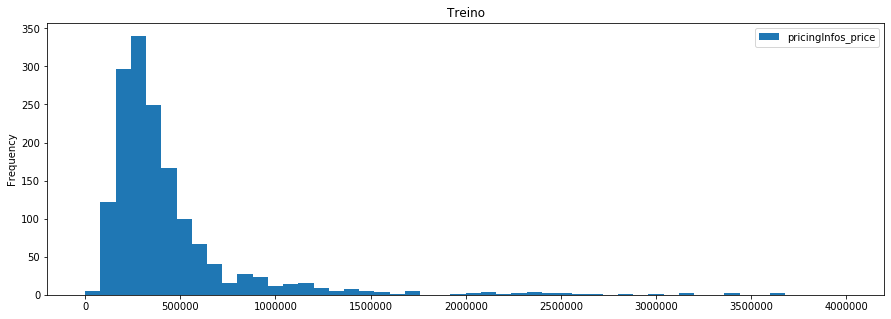

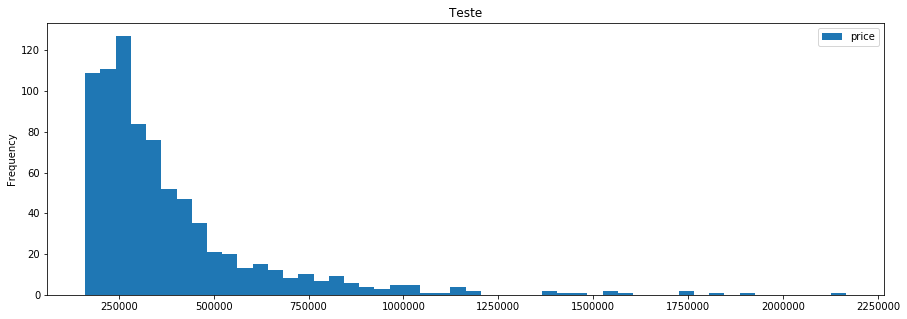

In [127]:
df_bairros_treino[['pricingInfos_price']].plot(
    kind='hist',
    range=(0,4000000),
    figsize=(15, 5),
    bins=50,
    title='Treino'
);

df_bairros_teste[['price']].plot(
    kind='hist',    
    figsize=(15, 5),
    bins=50,
    title='Teste'
);

# Criando um dataframe para comparar os resultados

In [128]:
df = pd.merge(df_bairros_treino, df_bairros_teste, how='left', left_on='address_neighborhood', right_on='address_neighborhood')

In [129]:
df.head()

,address_neighborhood,pricingInfos_price,price
0,A. Pinheiros,857150.0,664886.108482
1,Aclimação,594650.0,522132.424324
2,Adalgisa,840000.0,NaN
3,Aeroporto,407750.0,526472.218127
4,Agua Rasa,489999.0,NaN


In [130]:
df.rename(columns={'price':'predict_price'},inplace=True)

In [146]:
df.dtypes

address_neighborhood     object
pricingInfos_price       object
predict_price            object
variacao                float64
dtype: object

In [147]:
df['pricingInfos_price'] = df['pricingInfos_price'].astype(float)
df['predict_price'] = df['predict_price'].astype(float)

In [148]:
df['variacao'] = (df['predict_price']/df['pricingInfos_price']-1)

In [149]:
df['predict_price'].fillna(0, inplace=True)
df['variacao'].fillna(0, inplace=True)

In [151]:
df['predict_price'] = df['predict_price'].astype(str)
df['pricingInfos_price'] = df['pricingInfos_price'].astype(str)

### Exportando um arquivo csv para apoio nos gráficos 

In [153]:
df.to_csv(r'./perfomance_bairro_grad.csv', index=False)

# Mapa para Localização na Cidade de São Paulo

In [135]:
df_teste_sample = df_teste.sample(frac=0.03)

In [136]:
mapa_sp = folium.Map(
    location=[-23.557225, -46.658012],
    tiles='openstreetmap',
    zoom_start=11
)
mc = MarkerCluster()
    
for index, imovel in df_teste_sample.iterrows():
    mc.add_child(folium.Marker([imovel['geolocation_lat'], imovel['geolocation_lon']],              
              popup=str(imovel['description']),             
              tooltip="Valor: R$ " + str(round(imovel['price'])) + " Descrição: " + str(imovel['description']),              
              icon=folium.Icon(icon='book'))).add_to(mapa_sp)
mapa_sp

### Fiz um sample para a geração do mapa pois o Folium não trabalhou bem com milhares de pontos. Mas a ideia é que o usuário digite alguns parâmetros de busca de acordo com seu interesse.<br>
### Cada ponto plotado contém a informação de valor e a descrição (colocar o mouse em cima ou clicar nos circulos para expandir).